# **1. General** **Overview**

In [1]:
import pandas as pd

# Load dataset 
df = pd.read_csv("/Users/tharanidissanayake/Documents/TripAdvisor-Review-CW/data/dataset_raw.csv")

### Row count

In [2]:
print("Total number of reviews:", len(df))

Total number of reviews: 11829


### Unique counts

In [3]:
unique_hotels = df['placeName'].nunique()
unique_users = df['username'].nunique()
print("Unique hotels:", unique_hotels)
print("Unique users:", unique_users)

Unique hotels: 240
Unique users: 11198


### Review text length statistics

In [20]:
# Calculate average number of reviews per hotel
reviews_per_hotel = df.groupby('placeName')['review_text'].count()
print("Average reviews per hotel:", reviews_per_hotel.mean())

Average reviews per hotel: 49.28333333333333


### Review text length statistics

In [5]:
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
print(df['review_length'].describe())

count    11829.000000
mean        91.961451
std         79.909159
min          0.000000
25%         47.000000
50%         64.000000
75%        107.000000
max       1955.000000
Name: review_length, dtype: float64


# **2. Text** **Length** **Analysis**

In [6]:
import matplotlib.pyplot as plt

### Plot a Histogram

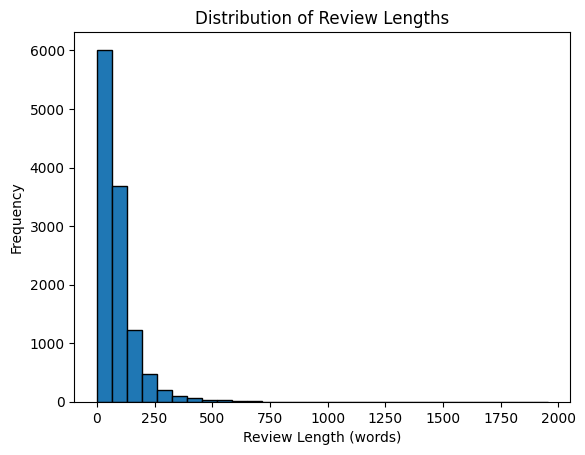

In [7]:
plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.show()

### Boxplot

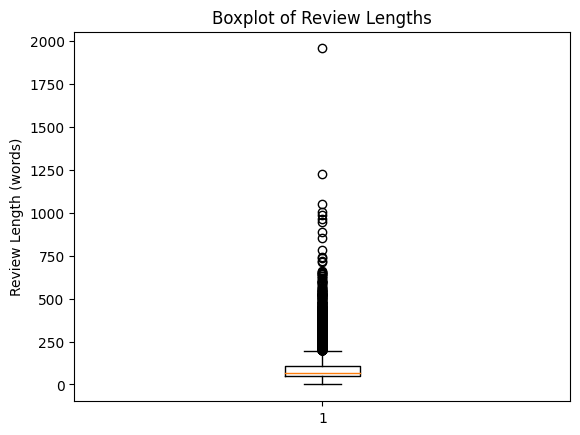

In [8]:
plt.boxplot(df['review_length'])
plt.title("Boxplot of Review Lengths")
plt.ylabel("Review Length (words)")
plt.show()

### Cumulative distribution

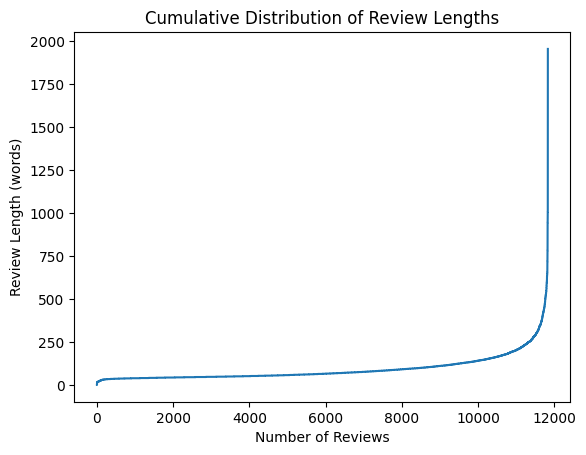

In [9]:
df['review_length'].sort_values().reset_index(drop=True).plot(drawstyle="steps-post")
plt.title("Cumulative Distribution of Review Lengths")
plt.xlabel("Number of Reviews")
plt.ylabel("Review Length (words)")
plt.show()

# **3. Word** **and** **Token** **Analysis**

In [10]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tharanidissanayake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Most common words

In [12]:
all_words = ' '.join(df['review_text'].dropna()).split()
word_freq = Counter(all_words).most_common(20)
print("Most Common Words:", word_freq)

Most Common Words: [('the', 51947), ('and', 46207), ('a', 26901), ('to', 26395), ('was', 20687), ('The', 15765), ('is', 15588), ('of', 15212), ('in', 14447), ('for', 12879), ('with', 11077), ('we', 10220), ('very', 10212), ('were', 8503), ('I', 8338), ('We', 7752), ('at', 6982), ('our', 6923), ('are', 6825), ('hotel', 6686)]


### Top N-grams

In [14]:
from nltk.util import ngrams

bigrams = ngrams(all_words, 2)
bigram_freq = Counter(bigrams).most_common(20)
print("Top Bigrams:", bigram_freq)

Top Bigrams: [(('in', 'the'), 4597), (('and', 'the'), 4568), (('of', 'the'), 4505), (('to', 'the'), 3418), (('from', 'the'), 2400), (('on', 'the'), 2221), (('at', 'the'), 2199), (('with', 'a'), 2053), (('is', 'a'), 1991), (('had', 'a'), 1862), (('the', 'hotel'), 1862), (('was', 'very'), 1835), (('it', 'was'), 1714), (('for', 'a'), 1714), (('The', 'staff'), 1664), (('was', 'a'), 1655), (('for', 'the'), 1611), (('friendly', 'and'), 1583), (('the', 'staff'), 1540), (('we', 'were'), 1433)]


### Vocabulary Size and Unique Word Ratio

In [16]:
vocab_size = len(set(all_words))
unique_ratio = vocab_size / len(all_words)
print("Vocabulary Size:", vocab_size)
print("Unique Word Ratio:", unique_ratio)

Vocabulary Size: 52084
Unique Word Ratio: 0.04787959684210139


# **4. Sentiment** **and** **Thematic** **Analysis**

### Keyword-based Sentiment exploration

In [17]:
sentiment_words = ['good', 'bad', 'amazing', 'terrible']
sentiment_counts = {word: all_words.count(word) for word in sentiment_words}
print("Sentiment Word Counts:", sentiment_counts)

Sentiment Word Counts: {'good': 4142, 'bad': 274, 'amazing': 1706, 'terrible': 74}


### Sentiment Score Distribution

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tharanidissanayake/nltk_data...


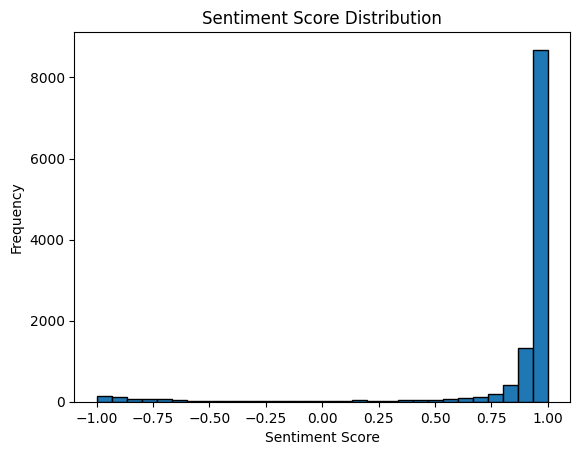

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['review_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'] if pd.notnull(x) else 0)

plt.hist(df['sentiment_score'], bins=30, edgecolor='black')
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

### Topic Modeling Preview

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assume df['review_text'] contains the text data
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
dtm = vectorizer.fit_transform(df['review_text'].dropna())  # Dropping NA values

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display top words in each topic
print("Top words in each topic:")
for index, topic in enumerate(lda.components_):
    print(f"Topic {index+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Get the topic distribution for each document
topic_distribution = lda.transform(dtm)

# Add the main topic for each review to the DataFrame
df = df.dropna(subset=['review_text']).reset_index(drop=True)  
df['main_topic'] = topic_distribution.argmax(axis=1)
df['topic_distribution'] = topic_distribution.tolist()  

# Display the DataFrame with the main topic and distribution for each review
print(df[['review_text', 'main_topic', 'topic_distribution']])


Top words in each topic:
Topic 1:
['good', 'clean', 'town', 'rooms', 'tuk', 'hotel', 'view', 'breakfast', 'room', 'ella']
Topic 2:
['excellent', 'amazing', 'friendly', 'great', 'good', 'stay', 'service', 'food', 'staff', 'hotel']
Topic 3:
['breakfast', 'rooms', 'nice', 'staff', 'stay', 'place', 'clean', 'great', 'good', 'beach']
Topic 4:
['hotel', 'amazing', 'wonderful', 'lovely', 'sri', 'beautiful', 'place', 'food', 'stay', 'staff']
Topic 5:
['water', 'place', 'breakfast', 'night', 'äôt', 'rooms', 'good', 'staff', 'hotel', 'room']
                                             review_text  main_topic  \
0      Very good service at Ayu and friendly staff. S...           1   
1      Change u r lady manager of u r hotel morning s...           4   
2      Just Perfect \nWe liked everything.\nStaffs ar...           1   
3      Our stay was unforgettable! The hotel was beau...           1   
4      Amazing hotel very well situated in Colombo! Y...           1   
...                           

# **5. POS Tag Analysis**

In [25]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt') # Download the punkt tokenizer

def pos_tag_review(review):
    tokens = nltk.word_tokenize(review)  # Tokenize the review into individual words
    return nltk.pos_tag(tokens)

pos_tags = df['review_text'].apply(pos_tag_review)
adj_count = sum([1 for tags in pos_tags for word, tag in tags if tag == 'JJ'])
print("Total adjectives:", adj_count)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total adjectives: 113322


# **6. Temporal Analysis**

<ipython-input-27-49ac259468c5>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('publishedDate')['review_text'].resample('M').count().plot()


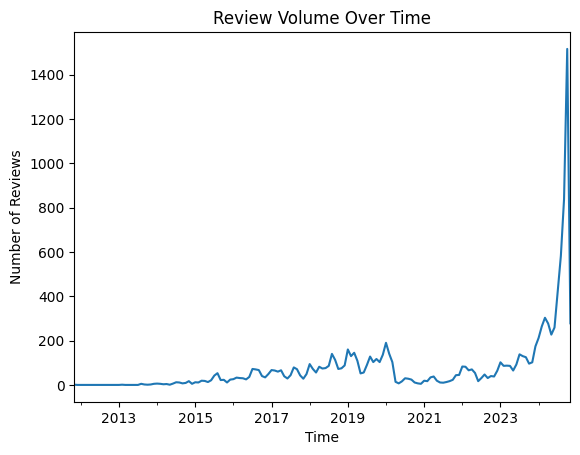

In [27]:
df['publishedDate'] = pd.to_datetime(df['publishedDate'])
df.set_index('publishedDate')['review_text'].resample('M').count().plot()
plt.title("Review Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.show()

# **7. Text Complexity and Readability**

In [29]:
!pip install textstat  # Installs the textstat library
import textstat # Imports the textstat


df['readability_score'] = df['review_text'].apply(lambda x: textstat.flesch_reading_ease(x) if pd.notnull(x) else 0)
print("Readability Scores:", df['readability_score'].describe())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00
Readability Scores: count    11829.000000
mean        73.712134
std         13.713523
min       -139.990000
25%         67.380000
50%         75.710000
75%         82.440000
max        121.220000
Name: readability_score, dtype: float64


# **8. Visualization Techniques**

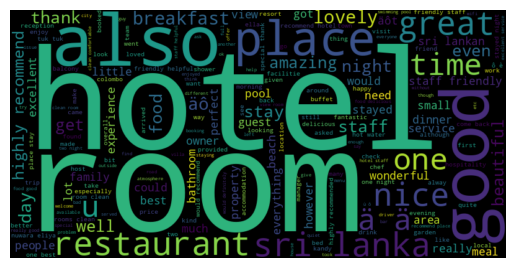

In [30]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, stopwords=stop_words).generate(' '.join(filtered_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()